In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from typing import Callable

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
def compare_lists(a, b):
  if collections.Counter(a) == collections.Counter(b):
    return True
  return False

In [21]:
def concept_drift_check(
    train_df, test_df, target_col=None, 
    plot_fi_diagram=False, plot_roc_auc=False, seed=42, 
    n_folds=5, early_stopping_rounds=10, iterations=5000):
  if target_col is not None:
    if target_col is not train_df.columns:
      raise KeyError('target_col is not in train_df.columns')
    train_df.drop('target_col', axis=1, inplace=True)
  
  if not compare_lists(train_df.columns, test_df.columns):
    raise NameError('Found difference in train_df.columns and test_df.columns')
  
  train_df['is_train'] = 1
  test_df['is_train'] = 0

  X = pd.concat([train_df, test_df], axis=0)
  y = X['is_train']
  X.drop('is_train', axis=1, inplace=True)

  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

  params = {
        'eval_metric': 'AUC',
        'learning_rate' : 0.05,
        'iterations': iterations,
    }

  cat = CatBoostClassifier(**params, random_seed=seed)

  scores = []

  for fold, (train_id, test_id) in enumerate(skf.split(X, y)):
    print('=' * 10)
    print('Processing for Fold no. ', fold)

    X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
    X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]

    print('X_train.shape : ', X_train.shape)

    cat.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=early_stopping_rounds
    )

    valid_pred = cat.predict_proba(X_valid)[:, 1]
    valid_score = roc_auc_score(y_valid, valid_pred)
    scores.append(valid_score)
    print('ROC_AUC score: ', valid_score)

  if plot_fi_diagram:
    cat.fit(
      X_train, y_train,
      verbose=False,
      early_stopping_rounds=early_stopping_rounds
    )
    plot_feature_importance(
        importance=cat.get_feature_importance(),
        names=X.columns, 
        model_type='CatBoostClassifier')
    plt.show()

  if plot_roc_auc:
    plt.figure(figsize=(10,8))
    plt.plot(scores)
    plt.ylim([0.0, 1.0])
    plt.title('CatBoostClassifier ROC_AUC on CV')
    plt.show()

  return np.mean(scores)

Ниже можно найти пример применения для California Housing Dataset

Processing for Fold no.  0
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5042303921568627
Processing for Fold no.  1
X_train.shape :  (16000, 8)
ROC_AUC score:  0.529925
Processing for Fold no.  2
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5091323529411764
Processing for Fold no.  3
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5245524509803922
Processing for Fold no.  4
X_train.shape :  (16000, 8)
ROC_AUC score:  0.5155458333333334


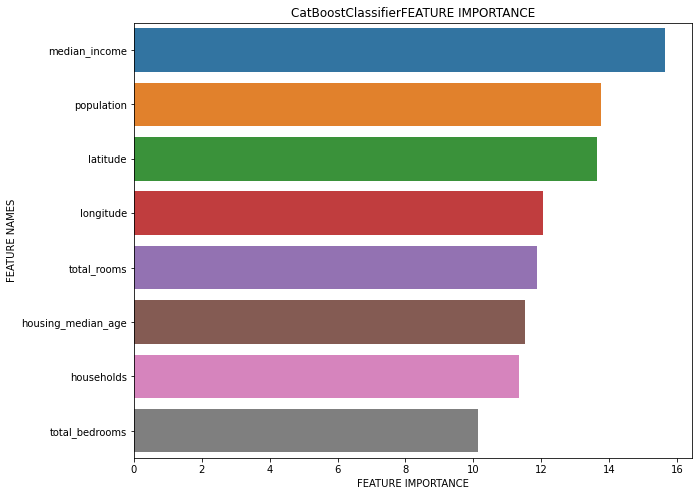

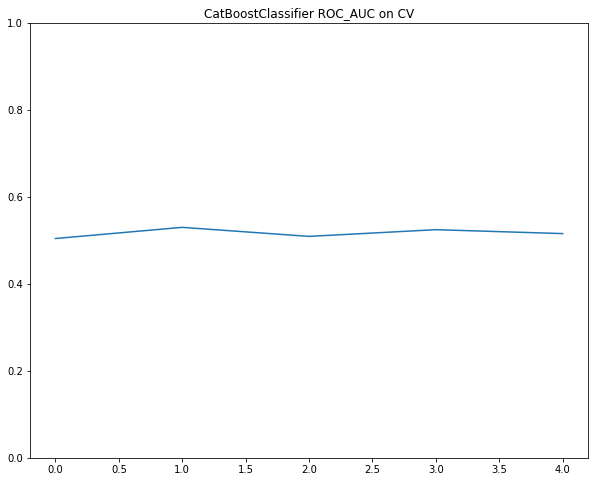

In [22]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
test = pd.read_csv('/content/sample_data/california_housing_test.csv')

train.drop(columns=['median_house_value'], axis=1, inplace=True)
test.drop(columns=['median_house_value'], axis=1, inplace=True)

mean_score = concept_drift_check(train, test, plot_fi_diagram=True, plot_roc_auc=True, iterations=2000)